## **House Price Prediction (Regression + Underfitting/Overfitting)**

### **Objective:** Build a regression model to predict median house value and study training error vs generalization error across different model complexities.

### 1. Import Libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [88]:
df = pd.read_csv('housing.csv')

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [90]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [91]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [92]:
print(df.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


### Handling the Missing Values in `total_bedrooms`

In [93]:
df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)

In [94]:
print(df['total_bedrooms'].isnull().sum())

0


### Handling the categorical column `ocean_proximity`
* Performing one hot encoding and droping the original column

In [95]:
df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [96]:
df_encoded = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=False)

In [97]:
df_encoded.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,False,True,False


### Feature Engineering
1. **Median Income** - Relationship with house value is non-linear (price increases faster at higher incomes).


In [98]:
df_encoded['log_median_income'] = np.log1p(df_encoded['median_income'])

2. **Rooms per household** - It Indicates average house size. Larger homes generally have higher prices.

In [99]:
df_encoded['rooms_per_household'] = (df_encoded['total_rooms'] / df_encoded['households'])

3. **Bedrooms per room** - Reflects house layout quality. Lower values imply more living space (hall, kitchen, etc.).

In [100]:
df_encoded['bedrooms_per_room'] = (df_encoded['total_bedrooms'] / df_encoded['total_rooms'])

4. **Population per household** - Measures crowding. High values indicate dense or lower-income housing.

In [101]:
df_encoded['population_per_household'] = (df_encoded['population'] / df_encoded['households'])

5. **Ocean proximity** - Coastal properties are significantly more expensive. Captures location premium not explained by latitude/longitude alone.

In [102]:
df_encoded['near_ocean'] = (
    df_encoded['ocean_proximity_NEAR OCEAN'] |
    df_encoded['ocean_proximity_<1H OCEAN']
).astype(int)

df_encoded['near_bay'] = df_encoded['ocean_proximity_NEAR BAY'].astype(int)

6. **Income × Rooms Interaction** - High Income and Large space houses indicates high pricing

In [103]:
df_encoded['income_rooms_interaction'] = df_encoded['median_income'] * df_encoded['rooms_per_household']

7. **Housing Median Age** - New houses and very old houses behave differently in pricing. Moderate impact but useful when combined with other features

In [104]:
df_encoded['housing_age_squared'] = (df_encoded['housing_median_age'] ** 2)

## Correlation Matrix

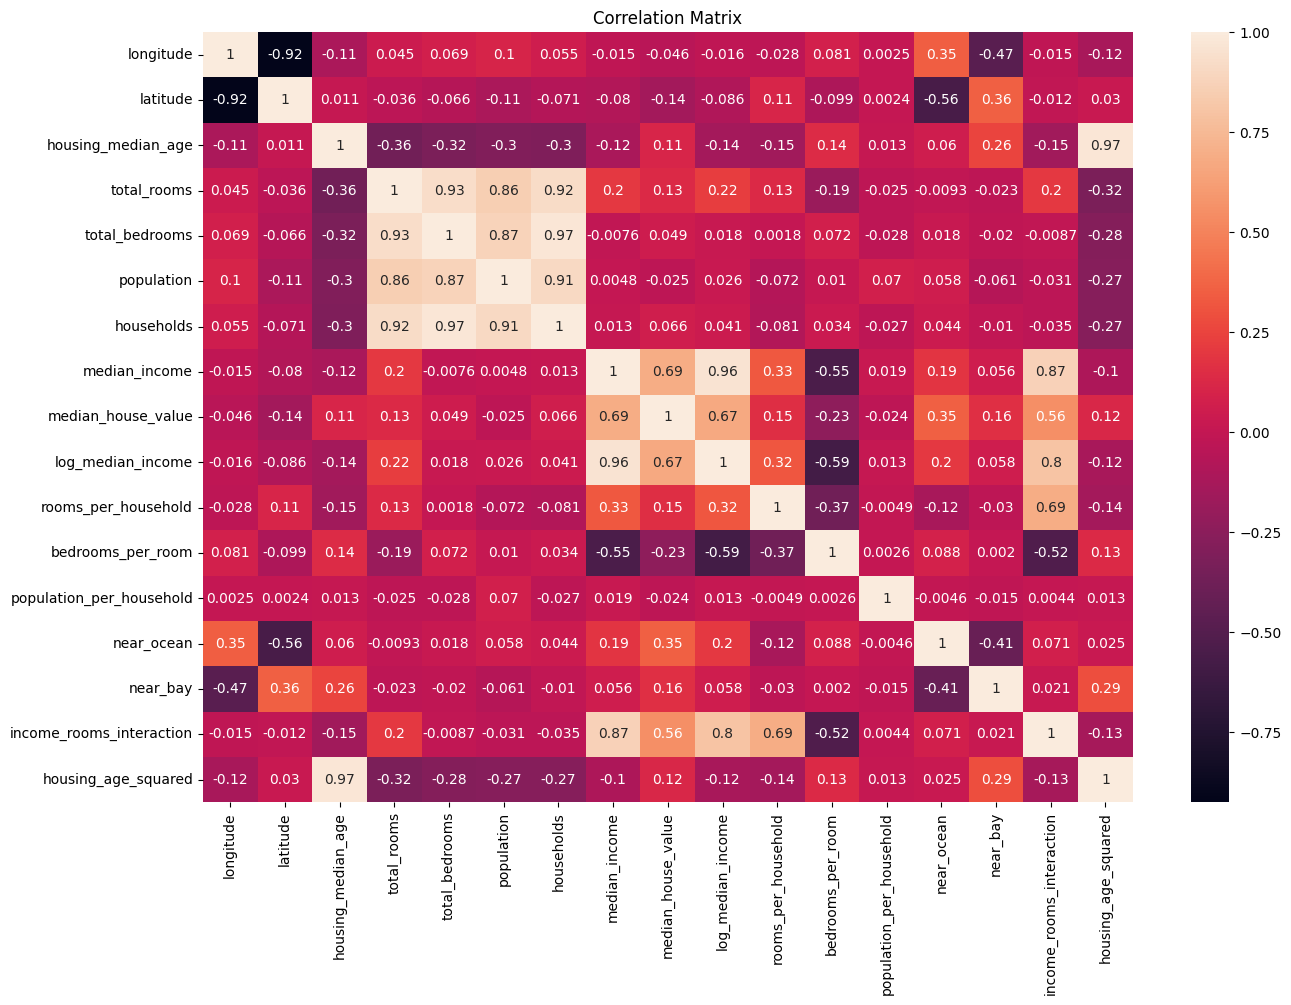

In [105]:
numeric_col = df_encoded.select_dtypes(include = ['int64', 'float64'])
corr_matrix = numeric_col.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [106]:
target_corr = corr_matrix['median_house_value'].sort_values(ascending=False)
print(target_corr)

median_house_value          1.000000
median_income               0.688075
log_median_income           0.669914
income_rooms_interaction    0.555438
near_ocean                  0.353582
near_bay                    0.160284
rooms_per_household         0.151948
total_rooms                 0.134153
housing_age_squared         0.119955
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049457
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.233303
Name: median_house_value, dtype: float64


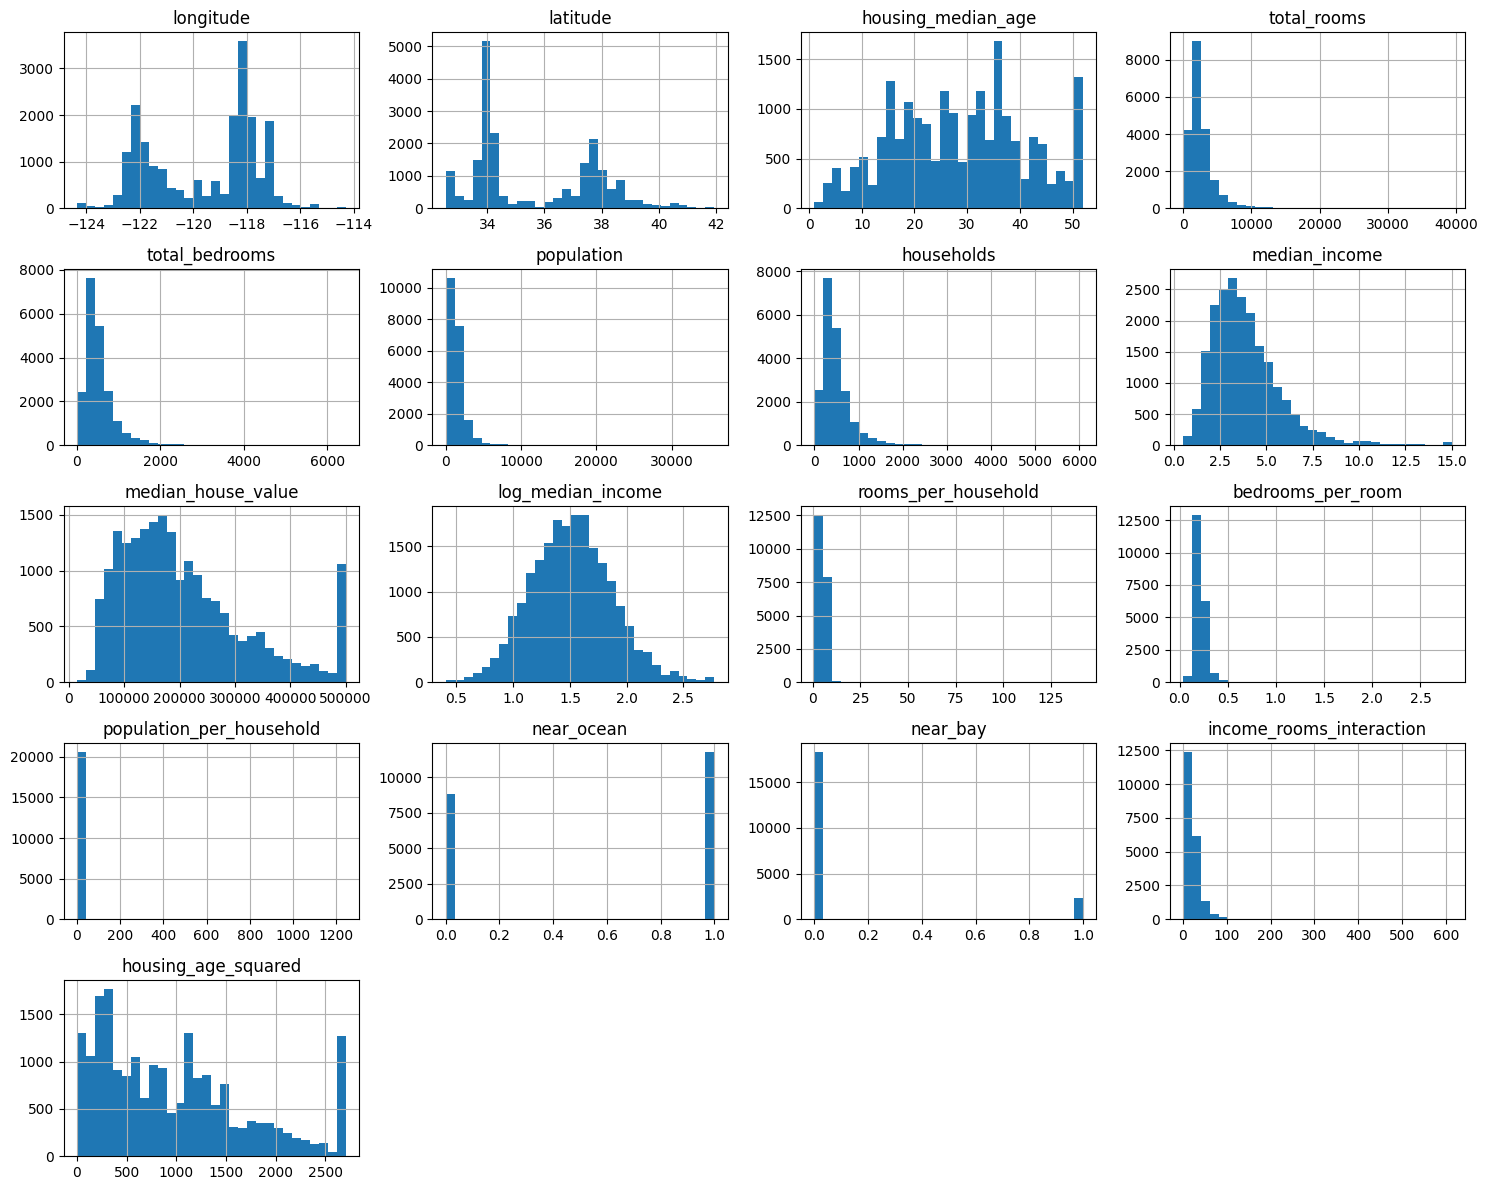

In [107]:
numeric_col.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()

In [108]:
Q1 = numeric_col.quantile(0.25)
Q3 = numeric_col.quantile(0.75)
IQR = Q3 - Q1

outliers = ((numeric_col < (Q1 - 1.5 * IQR)) |
            (numeric_col > (Q3 + 1.5 * IQR)))

print(outliers.sum().sort_values(ascending=False))

near_bay                    2290
total_bedrooms              1306
total_rooms                 1287
households                  1220
population                  1196
income_rooms_interaction    1111
median_house_value          1071
population_per_household     711
median_income                681
bedrooms_per_room            635
rooms_per_household          511
log_median_income            226
longitude                      0
housing_median_age             0
latitude                       0
near_ocean                     0
housing_age_squared            0
dtype: int64


### Handling Outliers
1. High Outliers (Expected & Normal)
| Feature              | Why Outliers Exist           | Action       |
| -------------------- | ---------------------------- | ------------ |
| `total_rooms`        | Large apartment complexes    |  Don’t drop |
| `total_bedrooms`     | Same as above                |  Don’t drop |
| `population`         | Dense city blocks            |  Don’t drop |
| `households`         | Large census tracts          |  Don’t drop |
| `median_house_value` | Price ceiling & luxury homes |  Don’t drop |
| `median_income`      | Wealthy regions              |  Don’t drop |

2. Ratio-Based Features
| Feature                    | Why Outliers Occur    | Best Action  |
| -------------------------- | --------------------- | ------------ |
| `rooms_per_household`      | Very small households | 🔄 Cap       |
| `population_per_household` | Shared housing        | 🔄 Cap       |
| `bedrooms_per_room`        | Data imbalance        | 🔄 Cap       |
| `income_rooms_interaction` | Multiplicative effect | 🔄 Log / Cap |

3. Location and Binary Features
| Feature      | Outliers | Why                           |
| ------------ | -------- | ----------------------------- |
| `longitude`  | 0        | Geographically bounded        |
| `latitude`   | 0        | Geographically bounded        |
| `near_ocean` | 0        | Binary                        |
| `near_bay`   | 2290     | Binary → IQR flags it falsely |


* **Log Transform Skewed Features**

In [109]:
skewed_features = [
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'income_rooms_interaction'
]

for col in skewed_features:
    df_encoded[col + '_log'] = np.log1p(df_encoded[col])

* **Cap Ratio Features (Winsorization)**

In [110]:
ratio_features = [
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room'
]

for col in ratio_features:
    lower = df_encoded[col].quantile(0.01)
    upper = df_encoded[col].quantile(0.99)
    df_encoded[col] = df_encoded[col].clip(lower, upper)

In [111]:
df_encoded['log_house_value'] = np.log1p(df_encoded['median_house_value'])

| Feature Type    | Treatment       |
| --------------- | --------------- |
| Raw counts      | Log transform   |
| Ratio features  | Cap (1%–99%)    |
| Binary features | Ignore outliers |
| Location        | Keep as-is      |
| Target          | Log transform   |

Observed outliers largely represent genuine real-estate extremes; therefore, log transformation and winsorization were applied instead of row removal to preserve valuable pricing signals.

### Categorical Correlation

1. **Category vs Target (Mean Comparison)**

In [112]:
cat_features = [
    'ocean_proximity_NEAR OCEAN',
    'ocean_proximity_<1H OCEAN',
    'ocean_proximity_NEAR BAY',
    'ocean_proximity_INLAND',
    'ocean_proximity_ISLAND'
]

for col in cat_features:
    mean_price = df_encoded[df_encoded[col] == 1]['median_house_value'].mean()
    count = df_encoded[df_encoded[col] == 1].shape[0]
    print(f"{col}: Mean Price = {mean_price:.2f}, Count = {count}")

ocean_proximity_NEAR OCEAN: Mean Price = 249433.98, Count = 2658
ocean_proximity_<1H OCEAN: Mean Price = 240084.29, Count = 9136
ocean_proximity_NEAR BAY: Mean Price = 259212.31, Count = 2290
ocean_proximity_INLAND: Mean Price = 124805.39, Count = 6551
ocean_proximity_ISLAND: Mean Price = 380440.00, Count = 5


2. **Box Plot**

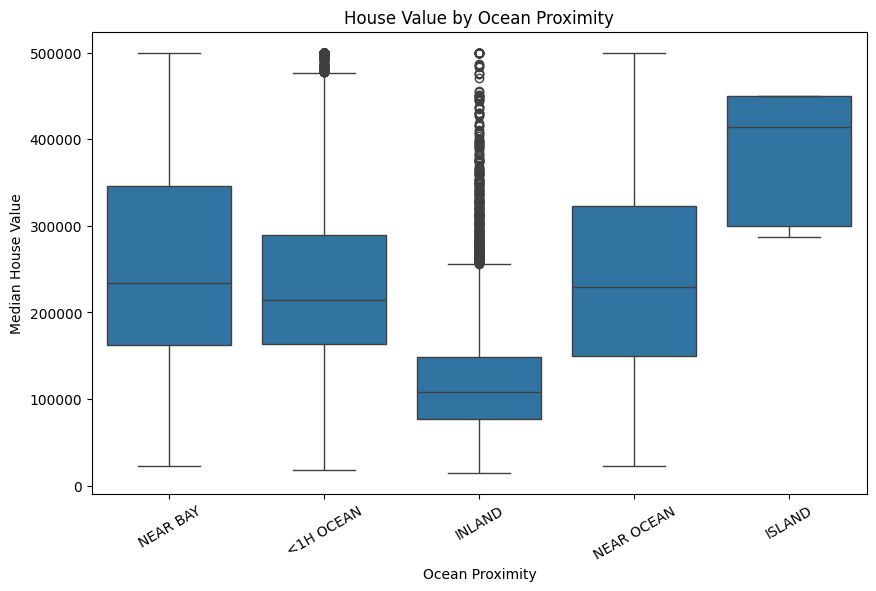

In [113]:
df_plot = df_encoded.copy()
df_plot['ocean_category'] = (df_plot[cat_features].idxmax(axis=1).str.replace('ocean_proximity_', ''))

plt.figure(figsize=(10, 6))
sns.boxplot(x='ocean_category', y='median_house_value', data=df_plot)
plt.xlabel('Ocean Proximity')
plt.ylabel('Median House Value')
plt.xticks(rotation=30)
plt.title("House Value by Ocean Proximity")
plt.show()


* **Outliers in this plot represent premium housing, not noise.
They validate ocean proximity as a powerful categorical predictor**

## Anova Test

In [114]:
from scipy.stats import f_oneway

groups = [
    df_encoded[df_encoded[col] == 1]['median_house_value']
    for col in cat_features
    if df_encoded[col].sum() > 0
]

f_stat, p_value = f_oneway(*groups)
print("ANOVA F-statistic:", f_stat)
print("p-value:", p_value)

ANOVA F-statistic: 1612.1407358838217
p-value: 0.0


### Interpretation -
* **F-statistic** measures how different the group means are relative to the variation within groups.
* A value this **high** means: The average house prices across ocean proximity categories are very different from each other.
* **Location (ocean proximity) has a very strong effect on house prices.**

* p-value ≈ 0 (practically zero)
* This means: **Probability that these differences happened by random chance is almost zero**

In [115]:
df_encoded.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,...,near_ocean,near_bay,income_rooms_interaction,housing_age_squared,total_rooms_log,total_bedrooms_log,population_log,households_log,income_rooms_interaction_log,log_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,...,0,1,58.144254,1681.0,6.781058,4.867534,5.777652,4.844187,4.079979,13.022766
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,...,0,1,51.785271,441.0,8.867850,7.009409,7.784057,7.037906,3.966232,12.789687
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,...,0,1,60.150315,2704.0,7.291656,5.252273,6.208590,5.181784,4.113335,12.771673
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,...,0,1,32.827897,2704.0,7.150701,5.463832,6.326149,5.393628,3.521286,12.740520
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,...,0,1,24.161264,2704.0,7.395108,5.638355,6.338594,5.560682,3.225306,12.743154


### Split Data

In [116]:
from sklearn.model_selection import train_test_split

features_lr = ['log_median_income', 'income_rooms_interaction', 'bedrooms_per_room',
               'near_ocean', 'near_bay', 'rooms_per_household', 'total_rooms',
               'housing_age_squared', 'housing_median_age',
               'ocean_proximity_NEAR OCEAN', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_NEAR BAY',
               'ocean_proximity_INLAND', 'ocean_proximity_ISLAND']

x_lr = df_encoded[features_lr]
y_lr = df_encoded['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(x_lr, y_lr, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (16512, 14)
X_test shape: (4128, 14)
y_train shape: (16512,)
y_test shape: (4128,)


### Feature Scaling

In [117]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train Linear Regression Model

In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_train_pred = lin_reg.predict(X_train_scaled)
y_test_pred = lin_reg.predict(X_test_scaled)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

if rmse_train < rmse_test * 0.9:
    fit_note = "Possibly overfitting (high variance)"
elif rmse_train > rmse_test * 1.1:
    fit_note = "Possibly underfitting (high bias)"
else:
    fit_note = "Good fit"

print(f"Linear Regression - Train RMSE: {rmse_train:.2f}")
print(f"Linear Regression - Test RMSE: {rmse_test:.2f}")
print(f"Linear Regression - Train MAE: {mae_train:.2f}")
print(f"Linear Regression - Test MAE: {mae_test:.2f}")
print(f"Fit Note: {fit_note}")

Linear Regression - Train RMSE: 71890.81
Linear Regression - Test RMSE: 75537.87
Linear Regression - Train MAE: 53307.08
Linear Regression - Test MAE: 54919.96
Fit Note: Good fit


### Train Ridge Regression Model

In [119]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)

y_train_pred_ridge = ridge_reg.predict(X_train_scaled)
y_test_pred_ridge = ridge_reg.predict(X_test_scaled)

rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
mae_train_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
mae_test_ridge = mean_absolute_error(y_test, y_test_pred_ridge)

if rmse_train_ridge < rmse_test_ridge * 0.9:
    fit_note = "Possibly overfitting (high variance)"
elif rmse_train_ridge > rmse_test_ridge * 1.1:
    fit_note = "Possibly underfitting (high bias)"
else:
    fit_note = "Good fit"

print(f"Ridge Regression - Train RMSE: {rmse_train_ridge:.2f}")
print(f"Ridge Regression - Test RMSE: {rmse_test_ridge:.2f}")
print(f"Ridge Regression - Train MAE: {mae_train_ridge:.2f}")
print(f"Ridge Regression - Test MAE: {mae_test_ridge:.2f}")
print(f"Fit Note: {fit_note}")


Ridge Regression - Train RMSE: 71890.81
Ridge Regression - Test RMSE: 75536.88
Ridge Regression - Train MAE: 53306.66
Ridge Regression - Test MAE: 54918.33
Fit Note: Good fit


### Decision Tree Model

In [120]:
x_dt = df_encoded.drop('median_house_value', axis=1)
y_dt = df_encoded['median_house_value']

X_dt_train, X_dt_test, y_train, y_test = train_test_split(x_dt, y_dt, test_size=0.2, random_state=42)

In [121]:
from sklearn.tree import DecisionTreeRegressor

max_depth_values = [3, 10, 20]

results_dt = []

for depth in max_depth_values:
    print(f"\nTraining Decision Tree Regressor with max_depth = {depth}")

    dt_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt_reg.fit(X_dt_train, y_train)

    y_train_pred_dt = dt_reg.predict(X_dt_train)
    y_test_pred_dt = dt_reg.predict(X_dt_test)

    rmse_train_dt = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
    rmse_test_dt = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))
    mae_train_dt = mean_absolute_error(y_train, y_train_pred_dt)
    mae_test_dt = mean_absolute_error(y_test, y_test_pred_dt)

    if rmse_train_dt < rmse_test_dt * 0.9:
        fit_note = "Possibly overfitting (high variance)"
    elif rmse_train_dt > rmse_test_dt * 1.1:
        fit_note = "Possibly underfitting (high bias)"
    else:
        fit_note = "Good fit"

    results_dt.append({
        'Max Depth': depth,
        'Train RMSE': rmse_train_dt,
        'Test RMSE': rmse_test_dt,
        'Train MAE': mae_train_dt,
        'Test MAE': mae_test_dt,
        'Fit Note': fit_note
    })

results_dt_df = pd.DataFrame(results_dt)
print("\nDecision Tree Results Summary:")
display(results_dt_df)



Training Decision Tree Regressor with max_depth = 3

Training Decision Tree Regressor with max_depth = 10

Training Decision Tree Regressor with max_depth = 20

Decision Tree Results Summary:


,Max Depth,Train RMSE,Test RMSE,Train MAE,Test MAE,Fit Note
0,3,15536.829004,15495.344585,13099.475600,13079.140900,Good fit
1,10,117.442030,157.197062,90.371579,107.942683,Possibly overfitting (high variance)
2,20,0.000000,106.936056,0.000000,25.726986,Possibly overfitting (high variance)


In [122]:
model_results = []

model_results.append({
    'Model': 'Linear Regression',
    'Train RMSE': rmse_train,
    'Test RMSE': rmse_test,
    'Train MAE': mae_train,
    'Test MAE': mae_test,
    'Fit Note': fit_note  # include fit note
})

model_results.append({
    'Model': 'Ridge Regression',
    'Train RMSE': rmse_train_ridge,
    'Test RMSE': rmse_test_ridge,
    'Train MAE': mae_train_ridge,
    'Test MAE': mae_test_ridge,
    'Fit Note': fit_note
})

for result in results_dt:
    model_results.append({
        'Model': f"Decision Tree (max_depth={result['Max Depth']})",
        'Train RMSE': result['Train RMSE'],
        'Test RMSE': result['Test RMSE'],
        'Train MAE': result['Train MAE'],
        'Test MAE': result['Test MAE'],
        'Fit Note': result['Fit Note']
    })

comparison_df = pd.DataFrame(model_results)

print("\nModel Performance Comparison:\n")
display(comparison_df.round(2))



Model Performance Comparison:



,Model,Train RMSE,Test RMSE,Train MAE,Test MAE,Fit Note
0,Linear Regression,71890.81,75537.87,53307.08,54919.96,Possibly overfitting (high variance)
1,Ridge Regression,71890.81,75536.88,53306.66,54918.33,Possibly overfitting (high variance)
2,Decision Tree (max_depth=3),15536.83,15495.34,13099.48,13079.14,Good fit
3,Decision Tree (max_depth=10),117.44,157.20,90.37,107.94,Possibly overfitting (high variance)
4,Decision Tree (max_depth=20),0.00,106.94,0.00,25.73,Possibly overfitting (high variance)


**Observations:**


1. Linear and Ridge Regression:
   * Train and test RMSE/MAE are similar → good fit, no major overfitting or underfitting.
   * Linear models capture overall trends well but may miss non-linear patterns in house prices.

2. Decision Tree (max_depth=3):
   * RMSE and MAE are low and balanced → good fit.
   * Underfitting avoided due to moderate depth.

3. Decision Tree (max_depth=10 and 20):
   * Training RMSE becomes extremely low (almost 0 for depth=20), while test RMSE is much higher → overfitting (high variance).
   * Model memorizes training data but fails to generalize.

4. Real-world ML Issues Observed:
   * Noisy features / outliers: Some extreme house prices affect Linear/Ridge predictions.
   * Non-linearity: Linear models cannot fully capture non-linear interactions (income × rooms).
   * Dataset bias: Regions near ocean are few → may bias the model if not handled.